# XGBoost

Zhanghan Wang, PB18111697

## Objective
\begin{align}
    \tilde{L}^{(t)}&=\sum\limits_{i=1}^n [g_if_t(\textbf{x}_i) + \frac{1}{2}h_if_t(\textbf{x}_i)]+\Omega(f_t)\\
    &=\sum\limits_{i=1}^n [g_if_t(\textbf{x}_i) + \frac{1}{2}h_if_t(\textbf{x}_i)]+\gamma T+\frac{1}{2}\lambda\sum\limits_{j=1}^T\omega_j^2\\
    &=\sum\limits_{j=1}^T\left[\left(\sum\limits_{i\in I_j}g_i\right)\omega_j+\frac{1}{2}\left(\sum\limits_{i\in I_j}h_i +\lambda \right)\omega^2_j\right]+\gamma T
\end{align}
where $$g_i=\partial_{\hat{y}^{(t-1)}}l(y_i,\hat{y}_i^{(t-1)})\quad \mbox{and} \quad h_i=\partial^2_{\hat{y}^{(t-1)}}l(y_i,\hat{y}_i^{(t-1)})$$
and $l(y_1, y_2)$ is the loss function

- note that in the code, I use $l(y_1, y_2)=\frac{1}{2}(y_1-y_2)^2$ as loss function, i.e.
$$g_i=\hat{y}^{(t-1)}-y_i\quad \mbox{and} \quad h_i=1$$

## Optimal Value

Thus, for a fixed tree structure, we have the optimal weights of leaves:
$$\omega^*_j=-\frac{\sum_{i\in I_j}g_i}{\sum_{i\in I_j}h_i+\lambda},$$
and the corresponding optimal value is
$$\tilde{\mathcal{L}}^{(t)}(q)=-\frac{1}{2}\sum\limits_{j=1}^T\frac{\left(\sum_{i\in I_j}g_i\right)^2}{\sum_{i\in I_j}h_i+\lambda}+\gamma T.$$

## Split Gain
With the $\tilde{\mathcal{L}}^{(t)}(q)$ above, we have
$$\mathcal{L}_{split}=\frac{1}{2}\left[\frac{\left(\sum_{i\in I_L}g_i\right)^2}{\sum_{i\in I_L}h_i+\lambda}+\frac{\left(\sum_{i\in I_R}g_i\right)^2}{\sum_{i\in I_R}h_i+\lambda}-\frac{\left(\sum_{i\in I}g_i\right)^2}{\sum_{i\in I}h_i+\lambda}\right]$$

In [1]:
import numpy as np

x_train = np.load('./data/train_data.npy')
y_train = np.load('./data/train_target.npy')
x_test = np.load('./data/test_data.npy')
y_test = np.load('./data/test_target.npy')

In [2]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_train[:10])
print(y_train[:10])

(615, 8) (615,)
(153, 8) (153,)
[[4.00e+00 1.54e+02 7.20e+01 2.90e+01 1.26e+02 3.13e+01 3.38e-01 3.70e+01]
 [2.00e+00 1.12e+02 8.60e+01 4.20e+01 1.60e+02 3.84e+01 2.46e-01 2.80e+01]
 [1.00e+00 1.35e+02 5.40e+01 0.00e+00 0.00e+00 2.67e+01 6.87e-01 6.20e+01]
 [3.00e+00 1.07e+02 6.20e+01 1.30e+01 4.80e+01 2.29e+01 6.78e-01 2.30e+01]
 [3.00e+00 1.02e+02 7.40e+01 0.00e+00 0.00e+00 2.95e+01 1.21e-01 3.20e+01]
 [1.00e+00 9.70e+01 6.60e+01 1.50e+01 1.40e+02 2.32e+01 4.87e-01 2.20e+01]
 [0.00e+00 1.04e+02 6.40e+01 2.30e+01 1.16e+02 2.78e+01 4.54e-01 2.30e+01]
 [7.00e+00 1.14e+02 6.60e+01 0.00e+00 0.00e+00 3.28e+01 2.58e-01 4.20e+01]
 [4.00e+00 8.30e+01 8.60e+01 1.90e+01 0.00e+00 2.93e+01 3.17e-01 3.40e+01]
 [0.00e+00 1.37e+02 8.40e+01 2.70e+01 0.00e+00 2.73e+01 2.31e-01 5.90e+01]]
[0 0 0 1 0 0 0 1 0 0]


In [3]:
import numpy as np
import networkx as nx
import os.path as osp
from collections import namedtuple
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

Criterion = namedtuple('Criterion', ('idx', 'threshold'))


class GradientTreeNode:
    def __init__(self, x_train, y_train, y_last_pred, lamb=1,
                 split_threshold_by_GH=False, split_threshold=0.1):
        assert len(x_train.shape) == 2
        assert len(y_train.shape) == 1
        assert x_train.shape[0] == y_train.shape[0]
        self.x_train = x_train
        self.y_train = y_train
        self.lamb = 1
        self.split_threshold_by_GH = split_threshold_by_GH
        self.split_threshold = split_threshold
        self.y_last_pred = y_last_pred
        self.g = self.g_func(self.y_train, self.y_last_pred)
        self.h = self.h_func(self.y_train, self.y_last_pred)
        self.G = self.g.sum()
        self.H = self.h.sum()
        if split_threshold_by_GH:
            self.split_threshold = np.sqrt(self.G**2 / (self.H + self.lamb))
        self.weight = -self.G / (self.H + self.lamb)
        self.left = None
        self.right = None
        self.criterion = Criterion('?', '?')

    def __repr__(self):
        if self.left is None and self.right is None:
            return f'{self.weight:.2f}'
        else:
            return f'x{self.criterion.idx}<{self.criterion.threshold: .2f}?'

    @property
    def feature_dim(self):
        return self.x_train.shape[1]

    @property
    def m(self):
        return self.x_train.shape[0]

    # gradient statistics
    @staticmethod
    def g_func(y_train, y_last_pred):
        return y_last_pred - y_train

    @staticmethod
    def h_func(y_train, y_last_pred):
        return np.ones(y_train.shape)

    def split(self):
        # datas
        x_train = self.x_train
        g, h = self.g, self.h
        G, H = self.G, self.H
        lamb = self.lamb
        # test if all instances are in the same class
        unique_y = np.unique(self.y_train)
        if unique_y.shape[0] == 1:
            return [self]
        # otherwise, find the best feature to split the node
        split = [0, 0]
        best_score = -np.inf
        gains = np.zeros((x_train.shape[-1::-1]))
        for k in range(self.feature_dim):
            G_L = 0
            H_L = 0
            args = np.argsort(x_train[:, k], axis=0)
            for i in range(len(args)):
                G_L += g[args[i]]
                H_L += h[args[i]]
                G_R = G - G_L
                H_R = H - H_L
                gain = G_L ** 2 / (H_L + lamb) + G_R ** 2 / (H_R + lamb) - G ** 2 / (H + lamb)
                gains[k][i] = gain
                if gain > best_score:
                    best_score = gain
                    split = [k, i]
        # test if best_score is less than the thershold
        if best_score < self.split_threshold:
            return [self]
        # otherwise, we can split this node
        args = np.argsort(x_train[:, split[0]], axis=0)
        self.criterion = Criterion(split[0], x_train[args[split[1]], split[0]])
        left_idx = args[:split[1] + 1]
        right_idx = args[split[1] + 1:]
        assert len(left_idx) > 0 and len(right_idx) > 0
        self.left = GradientTreeNode(self.x_train[left_idx], self.y_train[left_idx], self.y_last_pred[left_idx],
                                     self.lamb,
                                     split_threshold_by_GH=self.split_threshold_by_GH,
                                     split_threshold=self.split_threshold)
        self.right = GradientTreeNode(self.x_train[right_idx], self.y_train[right_idx], self.y_last_pred[right_idx],
                                      self.lamb,
                                      split_threshold_by_GH=self.split_threshold_by_GH,
                                      split_threshold=self.split_threshold)
        return self.left.split() + self.right.split()

    def predict(self, x):
        assert len(x.shape) == 1 and x.shape[0] == self.feature_dim
        criterion = self.criterion
        if self.left is None or self.right is None:
            return self.weight
        if x[criterion.idx] < criterion.threshold:
            return self.left.predict(x)
        else:
            return self.right.predict(x)


class GradientTree:
    def __init__(self, x_train, y_train, y_last_pred, lamb=1,
                 split_threshold_by_GH=False, split_threshold=0.01, gamma=1):
        self.x_train = x_train
        self.y_train = y_train
        self.y_last_pred = y_last_pred
        self.lamb = lamb
        self.split_threshold = split_threshold
        self.root = GradientTreeNode(x_train, y_train, y_last_pred, lamb=lamb,
                                     split_threshold_by_GH=split_threshold_by_GH,
                                     split_threshold=split_threshold)
        self.leaves = []
        self.graph = None
        self.gamma = gamma

    @property
    def obj(self):
        Gs = np.array([leaf.G for leaf in self.leaves])
        Hs = np.array([leaf.H for leaf in self.leaves])
        obj = -np.sum((Gs ** 2 / (Hs + self.lamb))) / 2 + self.gamma * len(self.leaves)
        return obj

    def train(self):
        self.leaves = self.root.split()

    def predict(self, x_test, y_test):
        correct_count = 0
        y_test_pred = []
        y_test_pred_prob = []
        for x, y in zip(x_test, y_test):
            y_pred_prob = self.root.predict(x)
            y_pred = 1 if y_pred_prob >= 0.5 else 0
            y_test_pred.append(y_pred)
            y_test_pred_prob.append(y_pred_prob)
            if y_pred == y:
                correct_count += 1
        acc = correct_count / len(y_test)
        y_test_pred = np.array(y_test_pred)
        y_test_pred_prob = np.array(y_test_pred_prob)
        return y_test_pred, y_test_pred_prob, acc

    def generate_graph(self):
        graph = nx.DiGraph()
        queue = [self.root]
        graph.add_nodes_from([(id(self.root), {'criterion': str(self.root)})])
        while len(queue) > 0:
            top = queue[0]
            queue = queue[1:]
            if top.left is None or top.right is None:
                assert top.left is None and top.right is None
                continue
            graph.add_nodes_from([(id(top.left), {'criterion': str(top.left)}),
                                  (id(top.right), {'criterion': str(top.right)})])
            graph.add_edges_from([(id(top), id(top.left)), (id(top), id(top.right))])
            queue.append(top.left)
            queue.append(top.right)
        self.graph = graph
        return graph

    def draw_tree(self):
        graph = self.generate_graph()
        labels = {}
        for node in graph.nodes.data():
            labels[node[0]] = node[1]['criterion']
        pos = graphviz_layout(graph, prog='dot')
        nx.draw(graph, pos=pos, with_labels=True, labels=labels)

In [4]:
import numpy as np
from typing import Union, List


class XGBoost:
    def __init__(self, x_train, y_train,
                 num_trees=10, lamb=1,
                 split_threshold_by_GH=False, split_threshold: Union[int, List, np.ndarray] = 1,
                 gamma=1):
        self.x_train = x_train
        self.y_train = y_train
        self.forest = []
        self.num_trees = num_trees
        self.lamb = lamb
        self.split_threshold_by_GH = split_threshold_by_GH
        self.split_threshold = split_threshold
        self.gamma = gamma

    def train(self):
        x_train = self.x_train
        y_train = self.y_train
        y_last_pred = np.zeros(y_train.shape)
        split_threshold = self.split_threshold
        if type(split_threshold) == int:
            np.repeat(split_threshold, self.num_trees)
        else:
            assert len(split_threshold) == self.num_trees

        for tree_idx in range(self.num_trees):
            gt = GradientTree(x_train, y_train, y_last_pred,
                              lamb=self.lamb,
                              split_threshold_by_GH=self.split_threshold_by_GH,
                              split_threshold=split_threshold[tree_idx], gamma=self.gamma)
            gt.train()
            self.forest.append(gt)
            y_last_pred += gt.predict(x_train, y_train)[1]

    def predict(self, x_test, y_test):
        y_test_pred_prob = np.zeros(y_test.shape)
        for gt in self.forest:
            y_test_pred_prob += gt.predict(x_test, y_test)[1]
        y_test_pred = np.array(list(map(lambda x: 1 if x > 0.5 else 0, y_test_pred_prob)))
        acc = np.sum(y_test_pred - y_test == 0) / y_test.shape[0]
        y_test_pred = np.array(y_test_pred)
        y_test_pred_prob = np.array(y_test_pred_prob)
        return y_test_pred, y_test_pred_prob, acc


[0.04040404 0.23529412 0.34375    0.6        0.62780269] 0.7463414634146341
[0.04040404 0.23529412 0.34375    0.62780269] 0.6993464052287581


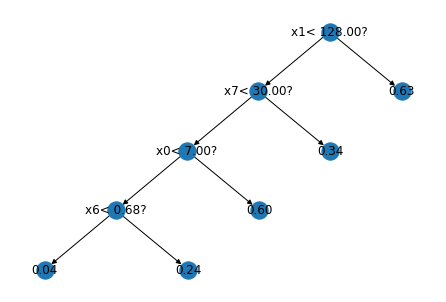

In [13]:
x_train = np.load('./data/train_data.npy')
y_train = np.load('./data/train_target.npy')
x_test = np.load('./data/test_data.npy')
y_test = np.load('./data/test_target.npy')

gt = GradientTree(x_train, y_train, np.zeros(y_train.shape), lamb=1, split_threshold=5, split_threshold_by_GH=True)
gt.train()
y_train_pred = gt.predict(x_train, y_train)
print(np.unique(y_train_pred[1]), y_train_pred[2])
y_test_pred = gt.predict(x_test, y_test)
print(np.unique(y_test_pred[1]), y_test_pred[2])
gt.draw_tree()

train acc: 0.8308943089430895
test acc: 0.7647058823529411


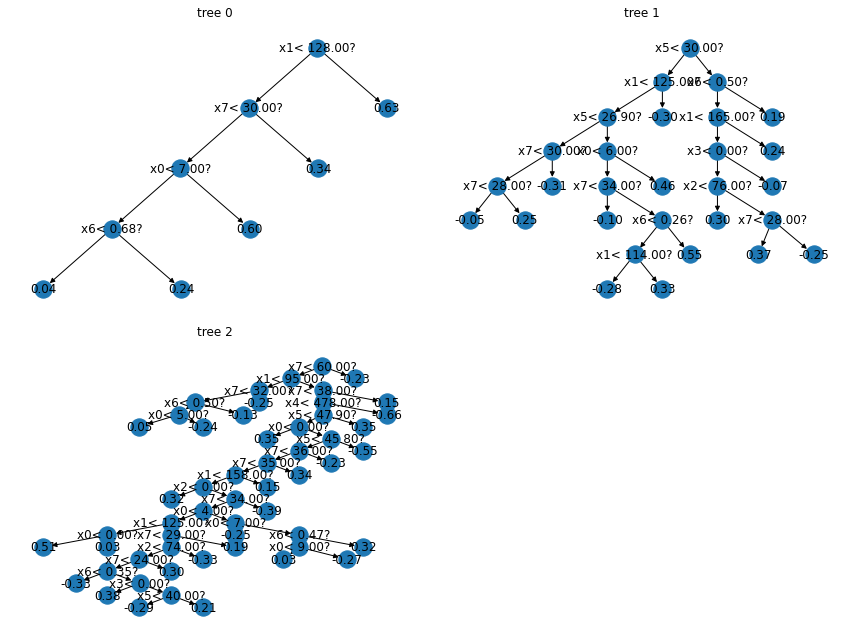

In [6]:
import numpy as np
import matplotlib.pyplot as plt


x_train = np.load('./data/train_data.npy')
y_train = np.load('./data/train_target.npy')
x_test = np.load('./data/test_data.npy')
y_test = np.load('./data/test_target.npy')

# split_threshold = [5]
split_threshold = [5, 2, 1.7]
xgb = XGBoost(x_train, y_train, num_trees=len(split_threshold), lamb=1,
              split_threshold_by_GH=True, split_threshold=split_threshold,
              gamma=1)
xgb.train()
y_train_pred = xgb.predict(x_train, y_train)
# print(np.unique(y_train_pred[1]))
print(f'train acc: {y_train_pred[2]}')
y_test_pred = xgb.predict(x_test, y_test)
# print(np.unique(y_test_pred[1]))
print(f'test acc: {y_test_pred[2]}')

fig = plt.figure(figsize=(12, 9))
subplot_size = [int(np.ceil(len(xgb.forest) / (int(np.sqrt(len(xgb.forest))) + 1))),
                int(np.sqrt(len(xgb.forest))) + 1]
for tree_idx, tree in enumerate(xgb.forest):
    ax = fig.add_subplot(*subplot_size, tree_idx+1)
    plt.title(f'tree {tree_idx}')
    tree.draw_tree()
plt.tight_layout()
plt.show()


In [7]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(x_train, y_train)
print(f'train acc: {np.sum(gbc.predict(x_train) - y_train == 0) / y_train.shape[0]}')
print(f'test acc: {np.sum(gbc.predict(x_test) - y_test == 0) / y_test.shape[0]}')

train acc: 0.9349593495934959
test acc: 0.7254901960784313
